In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf, beta as beta_func_val

In [4]:


# -----------------------
# Data (x, y)
# -----------------------
x_data = np.array([0.7070, 0.7693, 0.8372, 0.9110, 1.0788, 1.1739,
                   1.2774, 1.3901, 1.6460, 1.7912, 1.9491, 2.1210])
y_data = np.array([75.6757, 67.5676, 78.9474, 73.6842, 52.6316, 7.8947,
                   8.1081, 52.6316, 5.2632, 78.9474, 84.2105, 94.4444])

# -----------------------
# 1. Two-Sigmoid "Bump" Function
#    We use the difference of two sigmoids to create a function that is high at the boundaries
#    and low in the middle.
#    f(x) = U - (U - L) * [s2(x) - s1(x)]
# -----------------------
def two_sigmoid(x, L, U, x1, k1, x2, k2):
    s1 = 1.0 / (1 + np.exp(-k1 * (x - x1)))
    s2 = 1.0 / (1 + np.exp(-k2 * (x - x2)))
    return U - (U - L) * (s2 - s1)

# -----------------------
# 2. Inverted Skewed Gaussian Function
#    The standard skewed Gaussian (using an error function to introduce asymmetry)
#    is inverted here so that the minimum (at x = mu) becomes the low point.
#    f(x) = U - (U - L)*[exp(-((x-mu)^2/(2*sigma^2)))*(1 + erf(alpha*(x-mu)/(sqrt(2)*sigma)))]
#    Note: At x = mu, exp(0)=1 and erf(0)=0 so f(mu)=U - (U-L)=L.
# -----------------------
def skewed_gaussian_inverted(x, L, U, mu, sigma, alpha):
    return U - (U - L) * np.exp(-((x - mu)**2) / (2 * sigma**2)) * (1 + erf(alpha * (x - mu) / (np.sqrt(2) * sigma)))

# -----------------------
# 3. Beta Model (Inverted)
#    We use the beta probability density function (pdf) as a flexible shape on [0,1].
#    After rescaling x to [0,1] (see below), we form:
#      f(x) = L + (U - L) * [1 - pdf(x)/max_pdf]
#    so that at the mode (where pdf is maximum) f(x)=L and near the boundaries f(x)≈U.
# -----------------------
def beta_model(x, L, U, a, b):
    # x is assumed already rescaled to [0,1]
    B = beta_func_val(a, b)
    pdf = (x**(a - 1) * (1 - x)**(b - 1)) / B
    # Compute maximum of the pdf (if a, b > 1, the mode is at (a-1)/(a+b-2))
    if a > 1 and b > 1:
        mode = (a - 1) / (a + b - 2)
        pdf_max = (mode**(a - 1) * (1 - mode)**(b - 1)) / B
    else:
        xx = np.linspace(0, 1, 1000)
        pdf_grid = (xx**(a - 1) * (1 - xx)**(b - 1)) / B
        pdf_max = np.max(pdf_grid)
    return L + (U - L) * (1 - pdf / pdf_max)


Two-Sigmoid parameters: [  47.35712895   60.71032788    0.93405148 -152.74841166    1.07653193
  187.71350968]
Skewed Gaussian parameters: [ 48.1218979   91.22035288   1.74526404   0.57055935 -13.54717074]
Beta model parameters: [16.90246943 84.02364924  3.27450492  3.58149528]


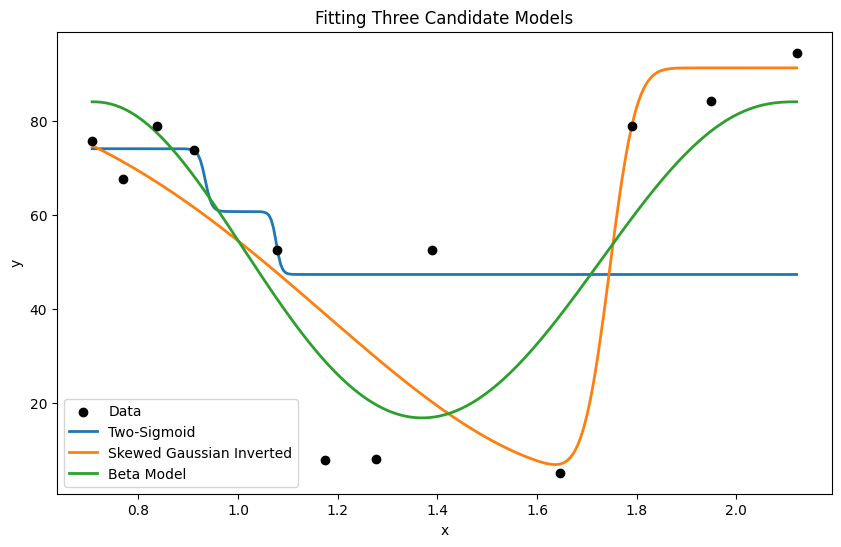

In [5]:
# -----------------------
# Rescale x for the beta model
# -----------------------
x_scaled = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data))

# -----------------------
# Fit the models using curve_fit
# -----------------------

# --- Two-Sigmoid ---
# p0 = [L, U, x1, k1, x2, k2]
p0_two = [5, 95, 1.0, 10, 1.5, 10]  # initial guesses
params_two, cov_two = curve_fit(two_sigmoid, x_data, y_data, p0=p0_two)
print("Two-Sigmoid parameters:", params_two)

# --- Skewed Gaussian Inverted ---
# p0 = [L, U, mu, sigma, alpha]
p0_skew = [5, 95, 1.3, 0.3, 1.0]  # initial guesses
params_skew, cov_skew = curve_fit(skewed_gaussian_inverted, x_data, y_data, p0=p0_skew)
print("Skewed Gaussian parameters:", params_skew)

# --- Beta Model ---
# p0 = [L, U, a, b]
p0_beta = [5, 95, 3, 3]  # initial guesses (with a,b>1 giving a central peak in the pdf)
params_beta, cov_beta = curve_fit(beta_model, x_scaled, y_data, p0=p0_beta)
print("Beta model parameters:", params_beta)

# -----------------------
# Plotting the fits
# -----------------------
x_fit = np.linspace(np.min(x_data), np.max(x_data), 300)
# For beta model, also rescale x_fit:
x_fit_scaled = (x_fit - np.min(x_data)) / (np.max(x_data) - np.min(x_data))

y_fit_two = two_sigmoid(x_fit, *params_two)
y_fit_skew = skewed_gaussian_inverted(x_fit, *params_skew)
y_fit_beta = beta_model(x_fit_scaled, *params_beta)

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='black', label='Data', zorder=5)
plt.plot(x_fit, y_fit_two, label='Two-Sigmoid', lw=2)
plt.plot(x_fit, y_fit_skew, label='Skewed Gaussian Inverted', lw=2)
plt.plot(x_fit, y_fit_beta, label='Beta Model', lw=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitting Three Candidate Models')
plt.legend()
plt.show()
